In [1]:
%load_ext autoreload
%autoreload 2

from text3d2video.pipelines.pipeline_utils import load_pipeline
import torch
from text3d2video.pipelines.controlnet_pipeline import BaseControlNetPipeline

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"
device = 'cuda'
pipe = load_pipeline(BaseControlNetPipeline, sd_repo, controlnet_repo)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [2]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact

from text3d2video.rendering import render_depth_map

rumba = AnimationArtifact.from_wandb_artifact_tag("rumba:latest")

frame_indices = rumba.frame_indices(5)
anim_cams, anim_meshes = rumba.load_frames(frame_indices)
anim_verts_uvs, anim_faces_uvs = rumba.uv_data()

all_meshes = anim_meshes
all_cams = anim_cams

depths = render_depth_map(all_meshes, all_cams)

100%|██████████| 30/30 [00:06<00:00,  4.76it/s]


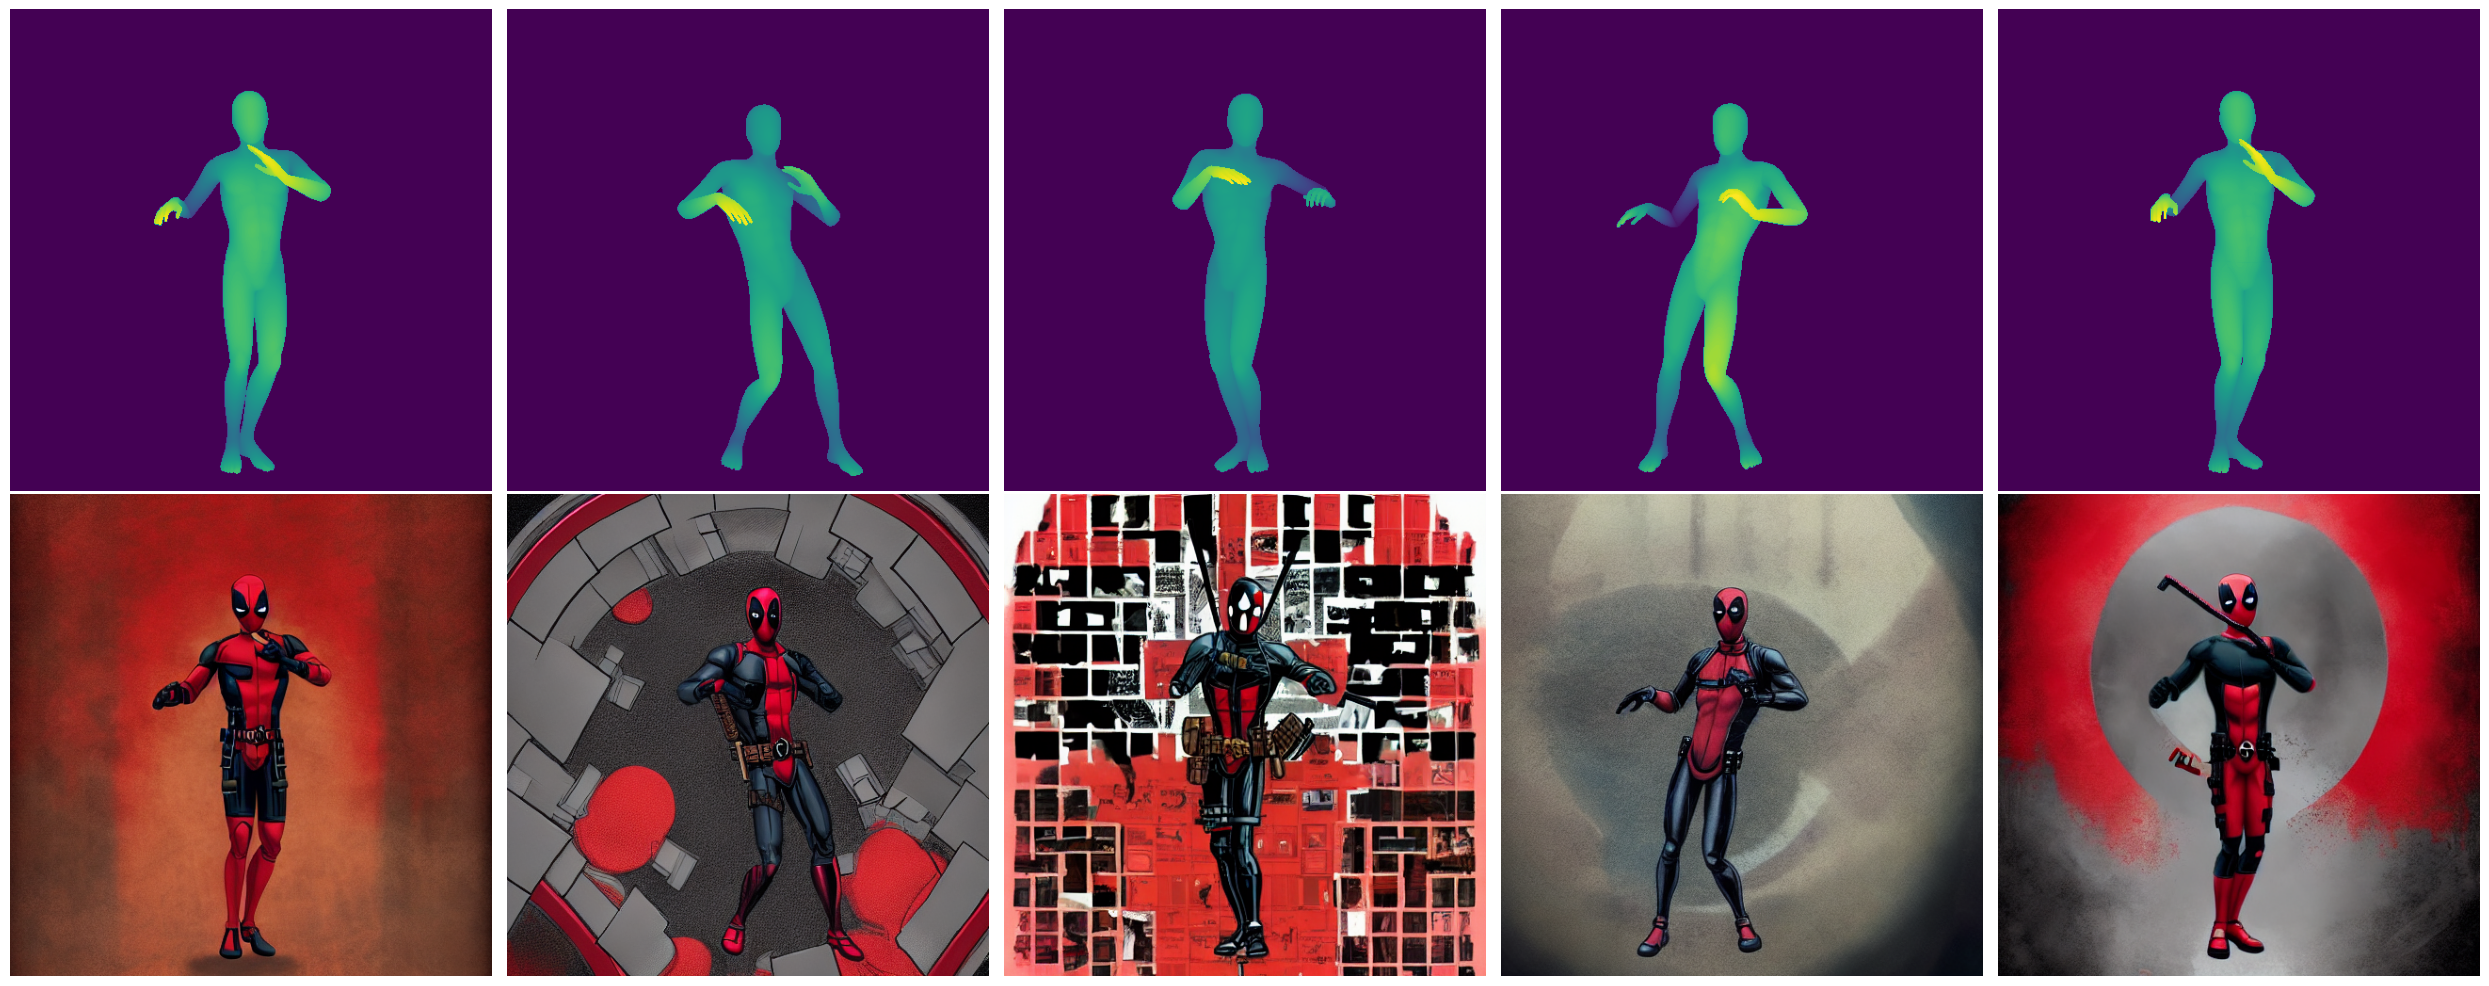

In [6]:
from pathlib import Path
from text3d2video.utilities.ipython_utils import display_ims_grid
from text3d2video.utilities.logging import GrLogger

prompt = "Deadpool"
seed = 1

gen = torch.Generator(device=device)
gen.manual_seed(seed)

logger = GrLogger(Path("data.h5"), n_save_times=10, n_save_frames=10)
logger.delete_data()
logger.open_write()
logger.enabled = True

images = pipe(
    [prompt] * len(depths),
    depths,
    generator=gen,
    num_inference_steps=30,
    controlnet_conditioning_scale=1,
    guidance_scale=7.5,
    logger=logger,
)

display_ims_grid([depths,images], scale=5)